In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import visualization
import datahandler

code is D0P7X9W6
['D0P7X9W6']
calm first: True


/home/jonathan/Desktop/Driving_Sim Stuff/driving_performance_project/datahandler.py:291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['Order'] = 'PN' if calmFirst else 'NP'
/home/jonathan/Desktop/Driving_Sim Stuff/driving_performance_project/datahandler.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['DrivingPerformance'] = normalized_distance * normalized_speed
/home/jonathan/Desktop/Driving_Sim Stuff/driving_performance_project/datahandler.py:300: SettingWithCopyWarning: 


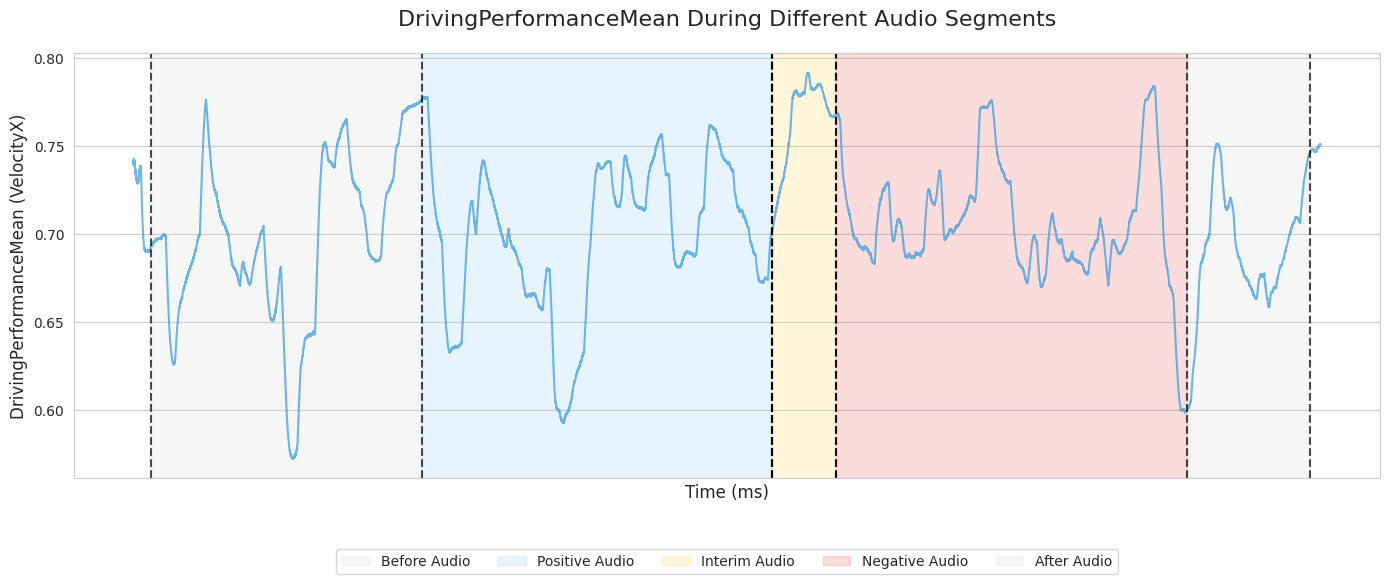

In [3]:
participant_code = 'D0P7X9W6' 
load_state_data = False
data_path = './participant data/'
trimmed_data, sections, gender, age, calmFirst = datahandler.load_participant(participant_code, data_path, load_state_data)

trimmed_data['DrivingPerformanceMean'] = trimmed_data['DrivingPerformance'].rolling(window=10000, min_periods=1000).mean()
print(f'calm first: {calmFirst}')
visualization.plot_column(trimmed_data, 'DrivingPerformanceMean', 'VelocityX', sections=sections)

In [4]:
def get_sign_windows(data, remove_nan=None, column='DistanceToNextSpeedSign', seconds=3):    
    speed_sign_data = data[data[column] == 0]
    speed_sign_data = speed_sign_data.drop_duplicates(subset=['Timestamp'])

    #drop rows around speed signs that are too close in time
    results = []
    last_event_time = None
    for idx, row in speed_sign_data.iterrows():
        current_time = row['Timestamp']
        if last_event_time is None or current_time - last_event_time >= seconds * 1000:
            results.append(row)
            last_event_time = current_time

    speed_sign_data = pd.DataFrame(results)
    amount_unique_signs = len(speed_sign_data)

    windows = pd.DataFrame(columns=speed_sign_data.columns)

    for i in range(len(speed_sign_data)):

        timestamp = speed_sign_data.iloc[i]['Timestamp']
        start_time = timestamp - seconds / 4 * 1000
        end_time = timestamp + seconds * 1000
        
        # Select the rows within the time window
        time_window_data = data[(data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time)]
        if remove_nan:
            time_window_data = time_window_data.dropna(subset=remove_nan)
        #remove empy or full nan columns    
        time_window_data = time_window_data.dropna(axis=1, how='all')
        windows = pd.concat([windows, time_window_data], ignore_index=True)


    windows = windows.sort_values(by='Timestamp')

    return windows, amount_unique_signs

In [5]:
# %matplotlib agg

_ = visualization.compare_perf_kdes(participant_code, get_sign_windows(trimmed_data)[0], sections=sections, save_path='./perf_plots/events_analysis/')
# %matplotlib inline

/tmp/ipykernel_5988/2548162100.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  windows = pd.concat([windows, time_window_data], ignore_index=True)


### Analyze distributions

In [6]:
import os
#surpress warnings
# import warnings
# warnings.filterwarnings("ignore")
from scipy.stats import skew


def get_all_stats(remove_outliers=None,
                  drop_gender=None,
                  drop_order=None,
                  save_folder=''):
  for root, dirs, files in os.walk(data_path):
    identifiers = [
        f.replace('.csv', '') for f in files
        if f != "W1D9N0B8.csv" and f != 'M3A2H7Q4.csv'
    ]
  print(identifiers)

  intense_stats = []
  calm_stats = []
  total_speed_signs = 0
  total_overhead_signs = 0
  total_data = None
  for id in identifiers:
    load_state_data = False

    try:
      trimmed_data, sections, gender, age, calmFirst = datahandler.load_participant(
          id, data_path, load_state_data, remove_outliers=remove_outliers)
      print(f'{id} OK')
      calmFirst = "PN" if calmFirst else "NP"
      if gender == drop_gender:
        print(f'Skipping {id} cause of gender')
        continue
      if drop_order and calmFirst == drop_order:
        print(f'Skipping {id} cause of order')
        continue
    except Exception as e:
      print(f'{id} FAIL')
      # print(e)
      continue

    # trimmed_data['VelocityXMean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
    # trimmed_data['DistanceToTargetPositionStd'] = trimmed_data['DistanceToTargetPosition'].rolling(window=10000).std()
    # trimmed_data['DistanceToTargetSpeed_Mean'] = trimmed_data['DistanceToTargetSpeed'].rolling(window=10000).mean()
    # trimmed_data['VelocityX_Mean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
    print(f'I got {trimmed_data['Participant'].unique()} as participant')
    windowed_data, amount_signs = get_sign_windows(trimmed_data,
                                                   remove_nan=remove_outliers,
                                                   seconds=3)
    print(f'Now I got {windowed_data['Participant'].unique()} as participant')
    total_speed_signs += amount_signs
    windowed_data2, amount_signs = get_sign_windows(
        trimmed_data,
        remove_nan=remove_outliers,
        column='DistanceToNextOverheadSign')
    total_overhead_signs += amount_signs

    windowed_data = pd.concat([windowed_data, windowed_data2],
                              ignore_index=True)
    windowed_data = windowed_data.sort_values(by='Timestamp')

    visualization.compare_perf_kdes(id,
                                    windowed_data,
                                    sections=sections,
                                    save_path=save_folder)

    pairs = [
        ('VelocityX', 'Lateral Velocity'),
        ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
        ('DistanceToTargetPosition', 'Distance to Correct Lane'),
        ('DrivingPerformance', 'Driving Performance'),
    ]

    for (col1, col2) in pairs:
      mean1, std1, mom1, mean2, std2, mom2 = datahandler.get_statistics(
          windowed_data, col1, col2, sections=sections)
      calm_stats.append((mean1, std1, mom1))
      intense_stats.append((mean2, std2, mom2))
    if total_data is None:
      print(f'Initializing {id} data')
      total_data = windowed_data.copy()
    else:
      print(f'Concatenating {id} data')
      print(f'total data unique: {total_data['Participant'].unique()}')
      print(f'windowed data unique: {windowed_data['Participant'].unique()}')
      total_data = pd.concat([total_data, windowed_data], ignore_index=True)

  total_data = total_data.sort_values(by='Timestamp')
  print(
      f'Total speed signs = {total_speed_signs}, total overhead signs = {total_overhead_signs}'
  )
  return calm_stats, intense_stats, total_data

In [7]:
def generate_datasets(calm_stats, intense_stats, pairs):
    N = len(pairs)      
    velocity_x_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 0]
    targ_speed_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 1]
    position_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 2]
    speed_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 3]
    velocity_x_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 0]
    targ_speed_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 1]
    position_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 2]
    speed_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 3]
    datasets = [[velocity_x_intense, velocity_x_calm],
                    [targ_speed_intense, targ_speed_calm],
                    [position_intense, position_calm],
                    [speed_intense, speed_calm]]
    return datasets


In [8]:
import scipy.stats as stats
from scipy.stats import ttest_rel
from scipy.stats import kruskal
from scipy.stats import wilcoxon

def print_statistical_tests(datasets, titles):
    for j, (intense, calm) in enumerate(datasets):
        print(f'\nT-test results for {titles[j]}, intense vs calm:')
        print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
        print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
        print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
        print(f'\nKruskal results for {titles[j]}, intense vs calm:')
        print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
        print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
        print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
        print(f'\nWilcoxn results for {titles[j]}, intense vs calm:')
        print(f'Means: {wilcoxon([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
        print(f'STDs: {wilcoxon([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
        print(f'Mom^3s: {wilcoxon([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')

In [9]:
#surpress warnings
import warnings
warnings.filterwarnings("ignore")



%matplotlib agg
calm_stats, intense_stats, data = get_all_stats(save_folder='perf_plots/events_analysis_all/', remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed', 'CarSpeed'])
%matplotlib inline

['G2Y7J4Q1', 'L0S1Z2I3', 'J4X1T0D2', 'V9L0P2K7', 'C1K4L9S8', 'L1N3B5O2', 'G9K4W1Z0', 'M4H6R2W9', 'M7D3F5K4', 'M0R6U5F9', 'O4A0U8R1', 'U6O5V2T9', 'I8L4N6G7', 'N7P5B8G0', 'D0P7X9W6', 'J6W7Q4H5', 'X5Q0G4J2', 'K4G7Y9O2']
code is G2Y7J4Q1
['G2Y7J4Q1']
G2Y7J4Q1 OK
I got ['G2Y7J4Q1'] as participant
Now I got ['G2Y7J4Q1'] as participant
Initializing G2Y7J4Q1 data
code is L0S1Z2I3
['L0S1Z2I3']
L0S1Z2I3 OK
I got ['L0S1Z2I3'] as participant
Now I got ['L0S1Z2I3'] as participant
Concatenating L0S1Z2I3 data
total data unique: ['G2Y7J4Q1']
windowed data unique: ['L0S1Z2I3']
code is J4X1T0D2
['J4X1T0D2']
J4X1T0D2 OK
I got ['J4X1T0D2'] as participant
Now I got ['J4X1T0D2'] as participant
Concatenating J4X1T0D2 data
total data unique: ['G2Y7J4Q1' 'L0S1Z2I3']
windowed data unique: ['J4X1T0D2']
code is V9L0P2K7
['V9L0P2K7']
V9L0P2K7 OK
I got ['V9L0P2K7'] as participant
Now I got ['V9L0P2K7'] as participant
Concatenating V9L0P2K7 data
total data unique: ['G2Y7J4Q1' 'L0S1Z2I3' 'J4X1T0D2']
windowed data uni

In [10]:
data['Participant'][data['Participant'] == 'J6W7Q4H5']

4264858    J6W7Q4H5
4264859    J6W7Q4H5
4264860    J6W7Q4H5
4264861    J6W7Q4H5
4264862    J6W7Q4H5
             ...   
4564844    J6W7Q4H5
4564845    J6W7Q4H5
4564846    J6W7Q4H5
4564847    J6W7Q4H5
4564848    J6W7Q4H5
Name: Participant, Length: 299991, dtype: object

In [11]:
#the max timestamps of each participant id
max_timestamps = data.groupby('Participant')['Timestamp'].max().reset_index()
max_timestamps['Timestamp'].sum() / 1000 / 60

np.float64(295.72433594666666)

In [12]:
300 / 2473 * 60

7.278608976951071

In [13]:
pairs = [
        ('VelocityX', 'Lateral Velocity'),
        ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
        ('DistanceToTargetPosition','Distance to Correct Lane'),
        ('DrivingPerformance', 'Driving Performance'),
        ]

titles = ['Lateral Velocity', 'Difference to Correct Speed', 'Distance to Correct Lane', 'Inverse Driving Performance']   
datasets = generate_datasets(calm_stats, intense_stats, pairs)
print_statistical_tests(datasets=datasets, titles=titles)
# datasets


T-test results for Lateral Velocity, intense vs calm:
Means: 0.2953621399995426
STDs: 0.080858081815419
Mom^3s: 0.1652999792899236

Kruskal results for Lateral Velocity, intense vs calm:
Means: 0.3929708076289571
STDs: 0.7758376742179307
Mom^3s: 0.5906763307135396

Wilcoxn results for Lateral Velocity, intense vs calm:
Means: 0.34654998779296875
STDs: 0.11870574951171875
Mom^3s: 0.1083831787109375

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.5580117850007273
STDs: 0.9949485975214492
Mom^3s: 0.662975783389625

Kruskal results for Difference to Correct Speed, intense vs calm:
Means: 0.7758376742179307
STDs: 0.7517095430780624
Mom^3s: 0.849441093557699

Wilcoxn results for Difference to Correct Speed, intense vs calm:
Means: 0.6396942138671875
STDs: 0.6094589233398438
Mom^3s: 0.83172607421875

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8046517256243098
STDs: 0.8780534458988539
Mom^3s: 0.9517903622384045

Kruskal results for Distan

In [14]:
{'postive':[float(calm_stats[i][0]) for i in range(72) if i % 4 == 3], 
 'negative':[float(intense_stats[i][0]) for i in range(72) if i % 4 == 3]}

{'postive': [0.612457762907403,
  0.6348654271275594,
  0.6453849131384591,
  0.6193820624576373,
  0.5394474918596129,
  0.5725774274090102,
  0.6103008568899849,
  0.6289543918824421,
  0.5050228181302646,
  0.336442478727869,
  0.6546372217235745,
  0.5011928831260367,
  0.42706575482876863,
  0.7017645097878048,
  0.6498986888617309,
  0.6620380807646578,
  0.6375013967420159,
  0.6584084965117794],
 'negative': [0.6146069007236092,
  0.6414979788926453,
  0.6062763301312352,
  0.6564758062035527,
  0.46331334971943244,
  0.48908146776047234,
  0.6402523003372457,
  0.6225583776305247,
  0.5733021333181383,
  0.3153062942108917,
  0.63756384768609,
  0.47287461250341345,
  0.4612992454268638,
  0.7100515027953312,
  0.6560573033536156,
  0.681845692924083,
  0.6255497280887703,
  0.5962608556731764]}

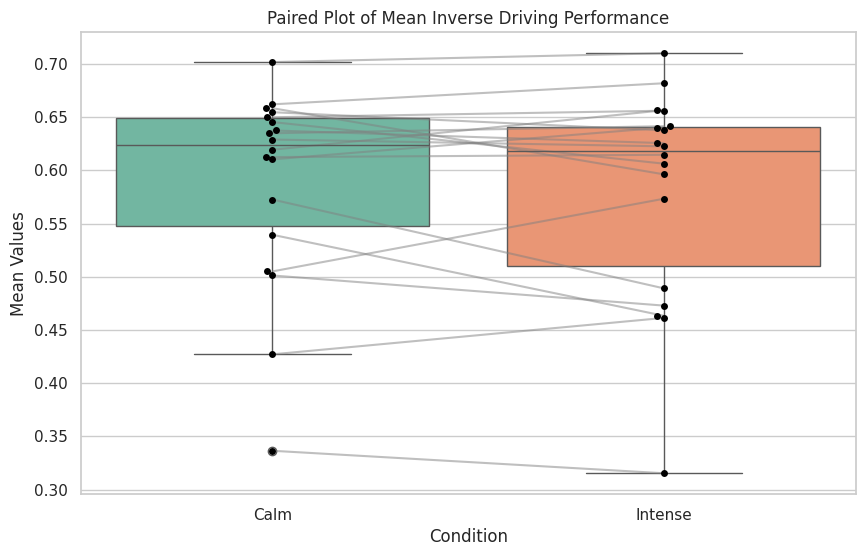

In [15]:
calm_data = pd.DataFrame(calm_stats, columns=['Mean', 'Std', 'Mom^3'])
intense_data = pd.DataFrame(intense_stats, columns=['Mean', 'Std', 'Mom^3'])

#create paired plot, like a box plot for each condition and then a line connecting each pair
def paired_plot(data1, data2, title, ylabel):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    
    # Create a DataFrame for the paired data
    N = len(data1)
    paired_data = pd.DataFrame({
        'Condition': ['Calm']  *( len(data1) // 4 ) + ['Intense'] *(len(data2) // 4 ),
        'Mean': [data1[i][0] for i in range(N) if i % 4 == 3] + [data2[i][0] for i in range(N) if i % 4 == 3],
        'Std': [data1[i][1] for i in range(N) if i % 4 == 3] + [data2[i][1] for i in range(N) if i % 4 == 3],
        'Mom^3':[data1[i][2] for i in range(N) if i % 4 == 3] + [data2[i][2] for i in range(N) if i % 4 == 3]
    })
    # Create the paired plot
    sns.boxplot(x='Condition', y='Mean', data=paired_data, palette="Set2")
    sns.swarmplot(x='Condition', y='Mean', data=paired_data, color='black')

    # print(paired_data['Mean'])
    for i in range(len(data1)):
        if i % 4 == 3:
            plt.plot(['Calm', 'Intense'], [data1[i][0], data2[i][0]], color='gray', alpha=0.5)
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

paired_plot(calm_stats, intense_stats, 'Paired Plot of Mean Inverse Driving Performance', 'Mean Values')


In [16]:
wilcoxon(calm_data['Std'], intense_data['Std']).pvalue

np.float64(0.6017486661800051)

In [ ]:
std_calm_target_speed = [calm_stats[i][1] for i in range(len(calm_stats)) if i % 4 == 1]
std_calm_target_lane = [calm_stats[i][1] for i in range(len(calm_stats)) if i % 4 == 2]

std_intense_target_speed = [intense_stats[i][1] for i in range(len(intense_stats)) if i % 4 == 1]
std_intense_target_lane = [intense_stats[i][1] for i in range(len(intense_stats)) if i % 4 == 2]


calm_perf = [x * y for x, y in zip(std_calm_target_speed, std_calm_target_lane)]
intense_perf = [x * y for x, y in zip(std_intense_target_speed, std_intense_target_lane)]

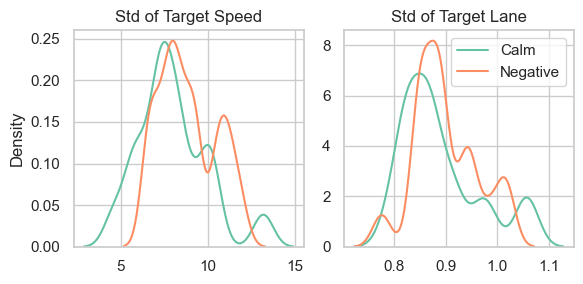

In [ ]:
fix, ax = plt.subplots(1,2, figsize=(6, 3))
sns.kdeplot(std_calm_target_speed, ax=ax[0], label='Positive', bw_adjust=0.5, color='#66c2a5')
sns.kdeplot(std_intense_target_speed, ax=ax[0], label='Negative', bw_adjust=0.5, color='#fc8d62')
sns.kdeplot(std_calm_target_lane, ax=ax[1], label='Calm',  bw_adjust=0.5, color='#66c2a5')
sns.kdeplot(std_intense_target_lane, ax=ax[1], label='Negative',  bw_adjust=0.5, color='#fc8d62')
plt.legend()
ax[1].set_ylabel('')
ax[0].set_title('Std of Target Speed')
ax[1].set_title('Std of Target Lane')
plt.tight_layout()



In [ ]:
wilcoxon(calm_perf, intense_perf).pvalue

np.float64(0.22875213623046875)

C:\Users\JonathanKubik\AppData\Local\Temp\ipykernel_18892\461055414.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Perf', data=paired_data, palette="Set2", width=0.5)


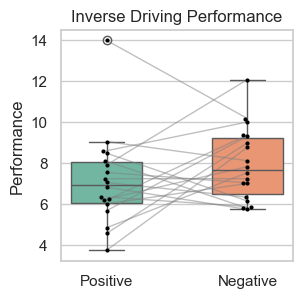

In [ ]:
paired_data = pd.DataFrame({
    'Condition': ['Positive'] * len(calm_perf) + ['Negative'] * len(intense_perf),
    'Perf': calm_perf + intense_perf
})


plt.figure(figsize=(3, 3))
sns.boxplot(x='Condition', y='Perf', data=paired_data, palette="Set2", width=0.5)
sns.swarmplot(x='Condition', y='Perf', data=paired_data, color='black', size=3)

# print(paired_data['Mean'])
for i in range(len(calm_perf)):

    plt.plot(['Positive', 'Negative'], [calm_perf[i], intense_perf[i]], color='gray', alpha=0.5, linewidth=1)
plt.title('Inverse Driving Performance')
plt.ylabel('Performance')
plt.xlabel('')
plt.savefig('perf_plots/combined_perf_boxplot.pdf', bbox_inches='tight')


C:\Users\JonathanKubik\AppData\Local\Temp\ipykernel_18892\4156482086.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Perf', data=paired_data, palette="Set2", width=0.5, ax=ax[2])


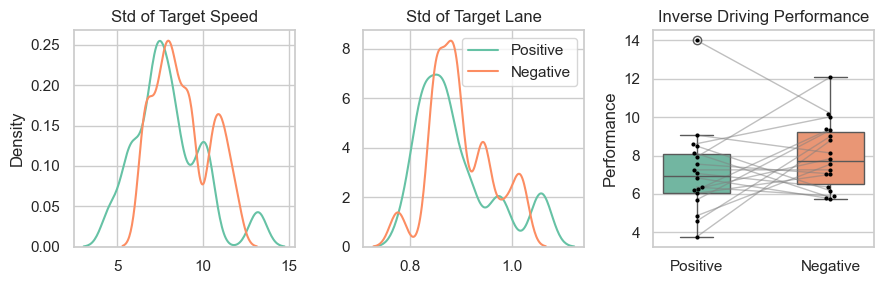

In [ ]:
fix, ax = plt.subplots(1,3, figsize=(9, 3))
sns.kdeplot(std_calm_target_speed, ax=ax[0], label='Positive', bw_adjust=0.45, color='#66c2a5')
sns.kdeplot(std_intense_target_speed, ax=ax[0], label='Negative', bw_adjust=0.45, color='#fc8d62')
sns.kdeplot(std_calm_target_lane, ax=ax[1], label='Positive',  bw_adjust=0.45, color='#66c2a5')
sns.kdeplot(std_intense_target_lane, ax=ax[1], label='Negative',  bw_adjust=0.45, color='#fc8d62')
ax[1].legend()
ax[1].set_ylabel('')
ax[0].set_title('Std of Target Speed')
ax[1].set_title('Std of Target Lane')



sns.boxplot(x='Condition', y='Perf', data=paired_data, palette="Set2", width=0.5, ax=ax[2])
sns.swarmplot(x='Condition', y='Perf', data=paired_data, color='black', size=3, ax=ax[2])

# print(paired_data['Mean'])
for i in range(len(calm_perf)):
    ax[2].plot(['Positive', 'Negative'], [calm_perf[i], intense_perf[i]], color='gray', alpha=0.5, linewidth=1)
plt.title('Inverse Driving Performance')
plt.ylabel('Performance')
plt.xlabel('')
plt.tight_layout()
plt.savefig('perf_plots/combined_perf_boxplot.pdf', bbox_inches='tight')

[np.float64(1.0208548576365313),
 np.float64(-3.222194720522668),
 np.float64(-1.3540690018127908),
 np.float64(0.09421635726306005),
 np.float64(-0.6429604082532444),
 np.float64(0.5111077438376042),
 np.float64(2.215232004668054),
 np.float64(-0.4339089771529485),
 np.float64(1.7345931290562187),
 np.float64(-0.2851997389431869),
 np.float64(-0.6832678989151546),
 np.float64(0.5564591667918797),
 np.float64(-0.8773249575151465),
 np.float64(0.4559995274722123),
 np.float64(2.7866772373757285),
 np.float64(2.024237361739163),
 np.float64(0.8382037084300851),
 np.float64(0.22902540727008258)]

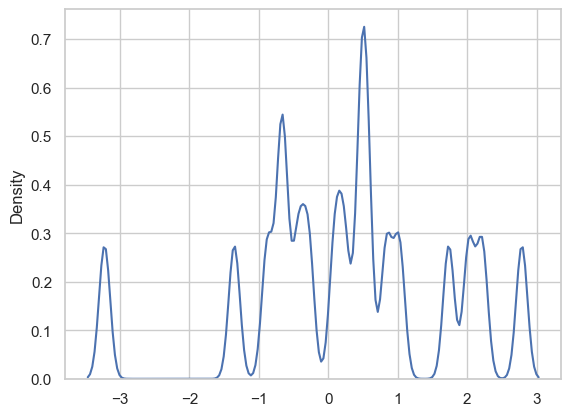

In [ ]:
data =  [intense_stats[i][0] - calm_stats[i][0] for i in range(len(intense_stats)) if i % 4 == 3]
sns.kdeplot(data, bw_adjust=0.1)
data

In [ ]:
len(calm_stats) // 4

18

In [ ]:
%matplotlib agg

intense_stats_wo, calm_stats_wo = get_all_stats(remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/wo/')
dataset_wo = generate_datasets(calm_stats=calm_stats_wo, intense_stats=intense_stats_wo, pairs=pairs)

%matplotlib inline

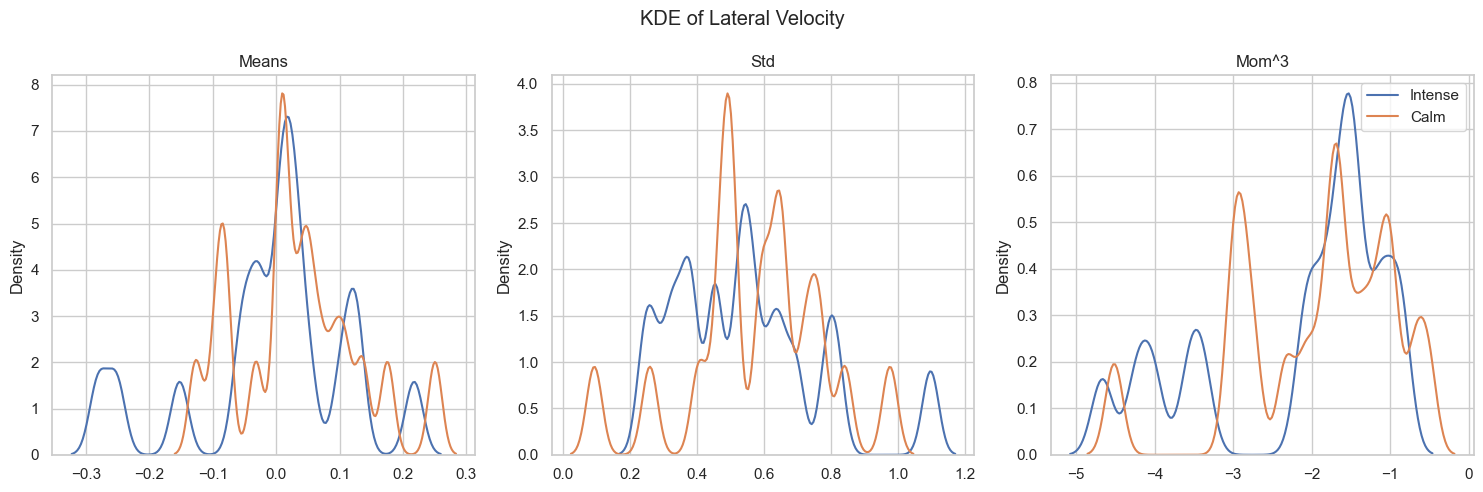

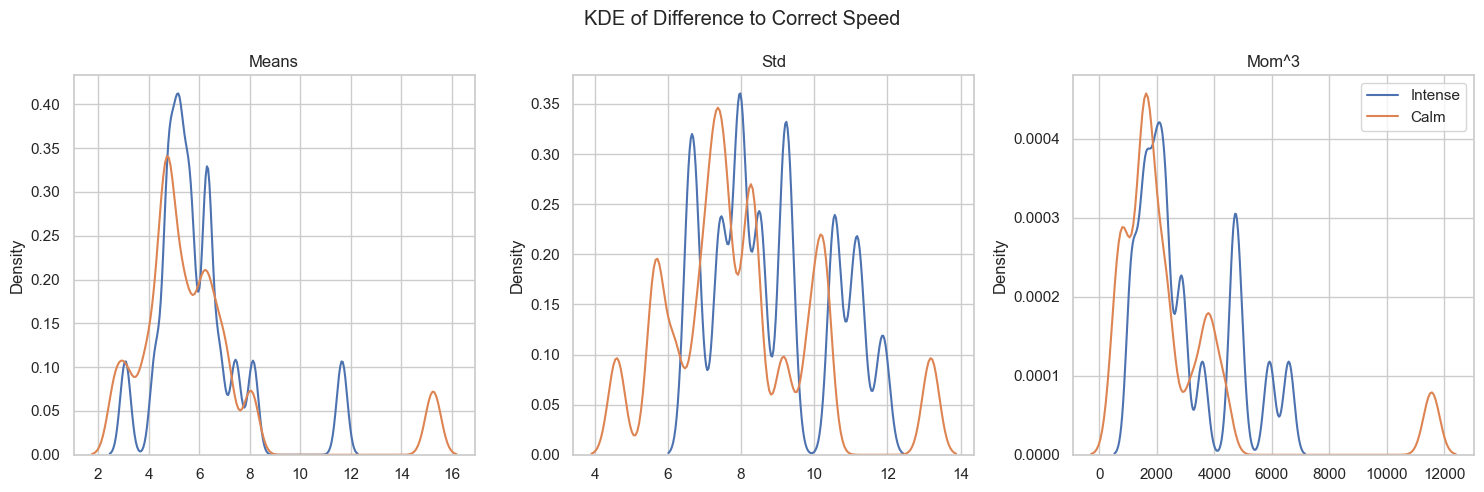

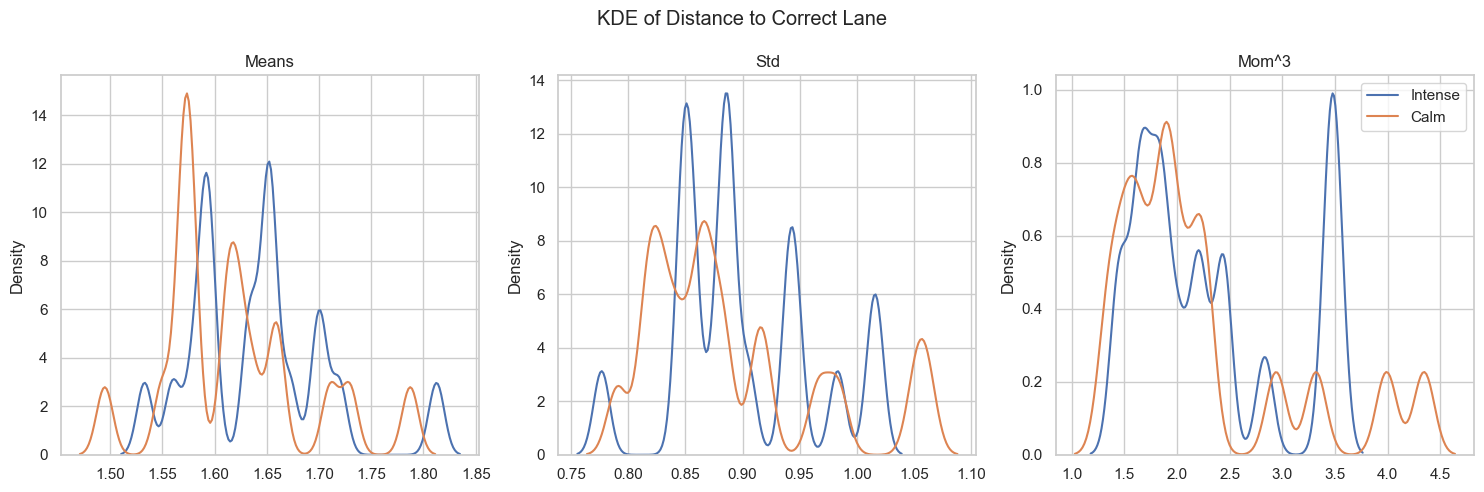

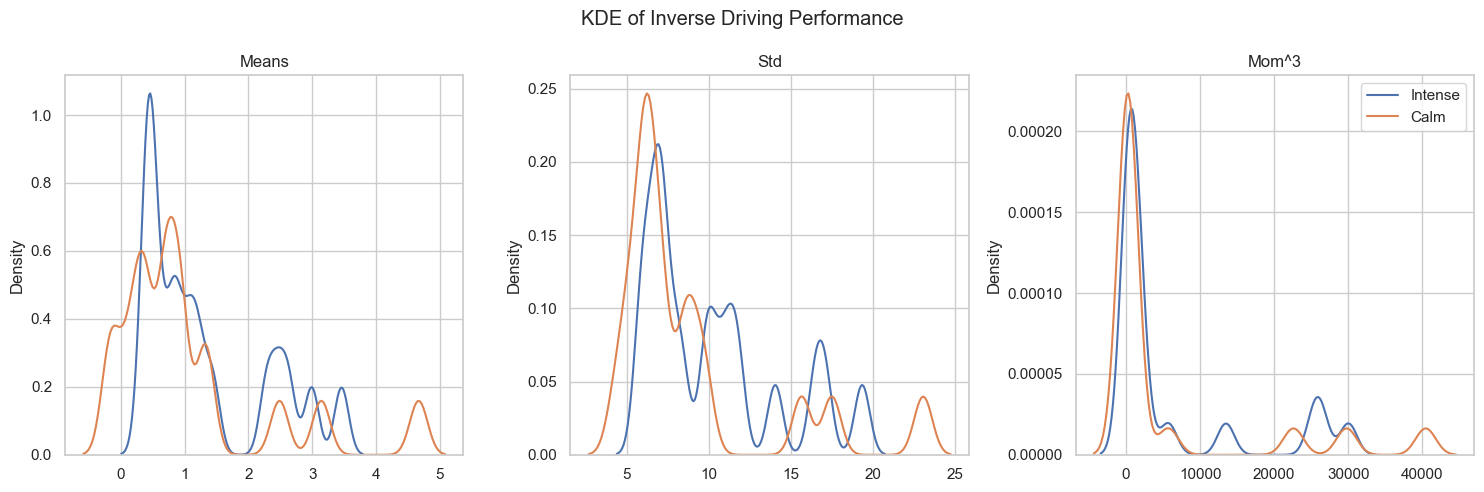

In [ ]:
pairs = [
        ('VelocityX', 'Lateral Velocity'),
        ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
        ('DistanceToTargetPosition','Distance to Correct Lane'),
        ('DrivingPerformance', 'Driving Performance'),
        ]

datasets = generate_datasets(calm_stats=calm_stats, intense_stats=intense_stats, pairs=pairs)
titles = ['Lateral Velocity', 'Difference to Correct Speed', 'Distance to Correct Lane', 'Inverse Driving Performance']   

def plot_all_perf_param_kdes(datasets=datasets, titles=titles):
    for j, (intense, calm) in enumerate(datasets):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i in range(3):
            sns.kdeplot([x[i] for x in intense], label=f'Intense', ax=axes[i], bw_adjust=0.2)
            sns.kdeplot([x[i] for x in calm], label=f'Calm', ax=axes[i], bw_adjust=0.2)
            axes[i].set_title(f'{['Means', 'Std', 'Mom^3'][i]}')
        plt.suptitle(f'KDE of {titles[j]}')
        plt.tight_layout()
        plt.savefig('kde_lateral_velocity_statistics.png', dpi=300)
        plt.legend()
        plt.show()

plot_all_perf_param_kdes(datasets=datasets, titles=titles)

In [ ]:

def plot_all_boxplot_perf(datasets=datasets, titles=titles):
    for j, (intense, calm) in enumerate(datasets):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i in range(3):
            sns.boxplot({'Negative':[x[i] for x in intense], 'Positive':[x[i] for x in calm]}, ax=axes[i],palette={'Negative':'tomato', 'Positive':'skyblue'} )
            sns.swarmplot({'Negative':[x[i] for x in intense], 'Positive':[x[i] for x in calm]}, ax=axes[i], color='black', alpha=0.5)
            axes[i].set_title(f'{['Means', 'Std', 'Mom^3'][i]}')
        plt.suptitle(f'Boxplot of {titles[j]}')
        plt.tight_layout()
        plt.savefig('boxplot.png', dpi=300)
        # plt.legend()
        plt.show()

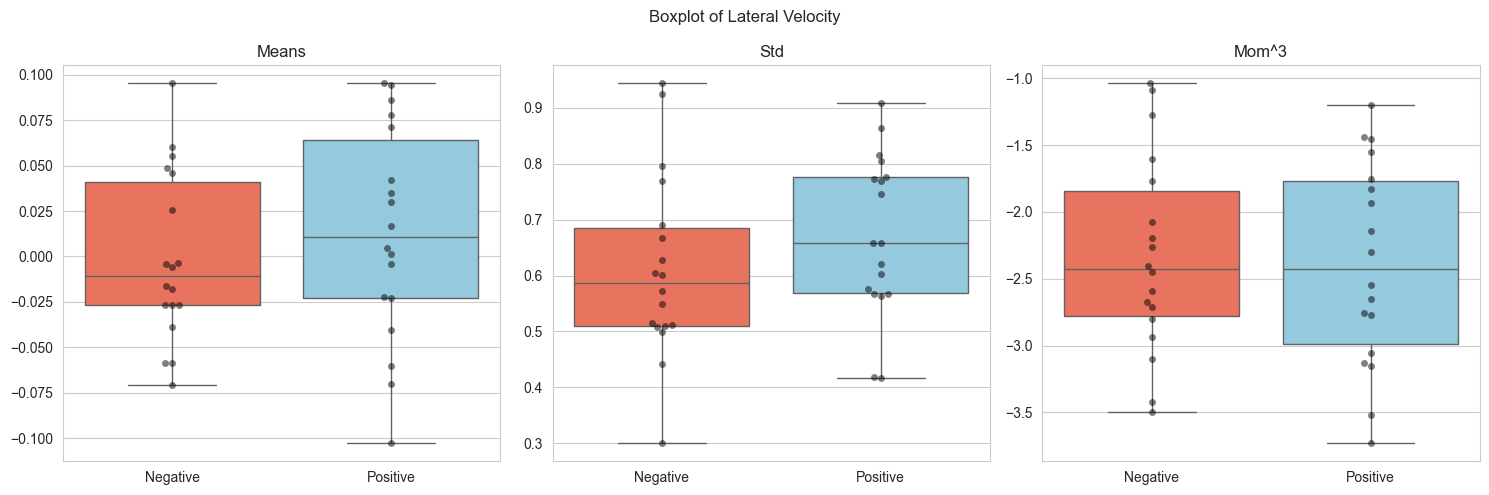

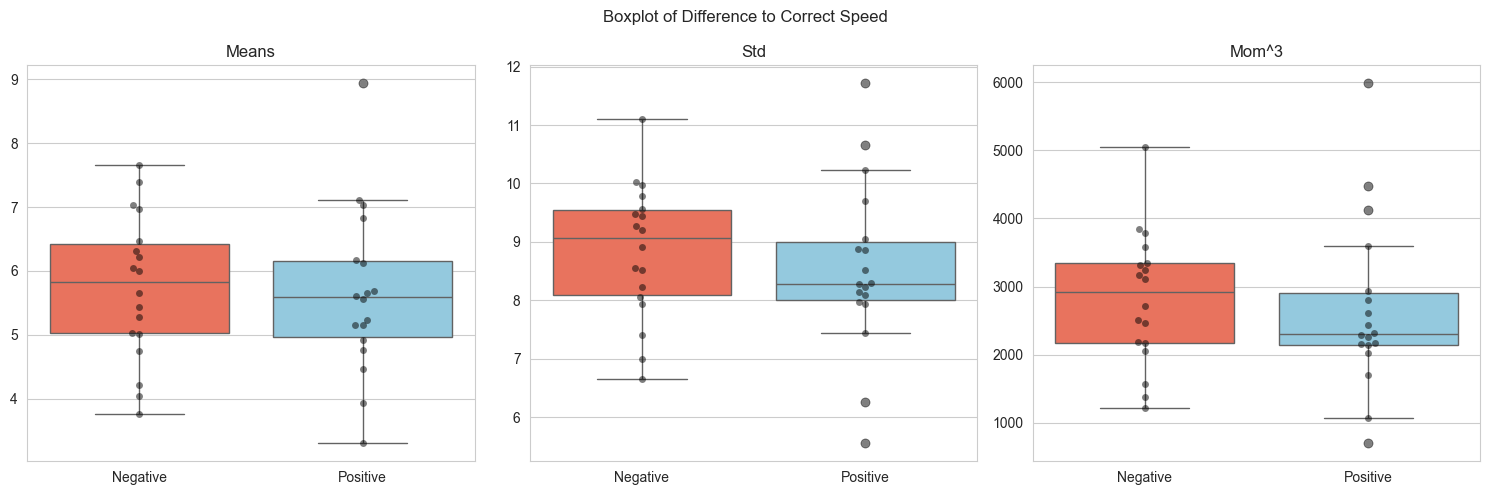

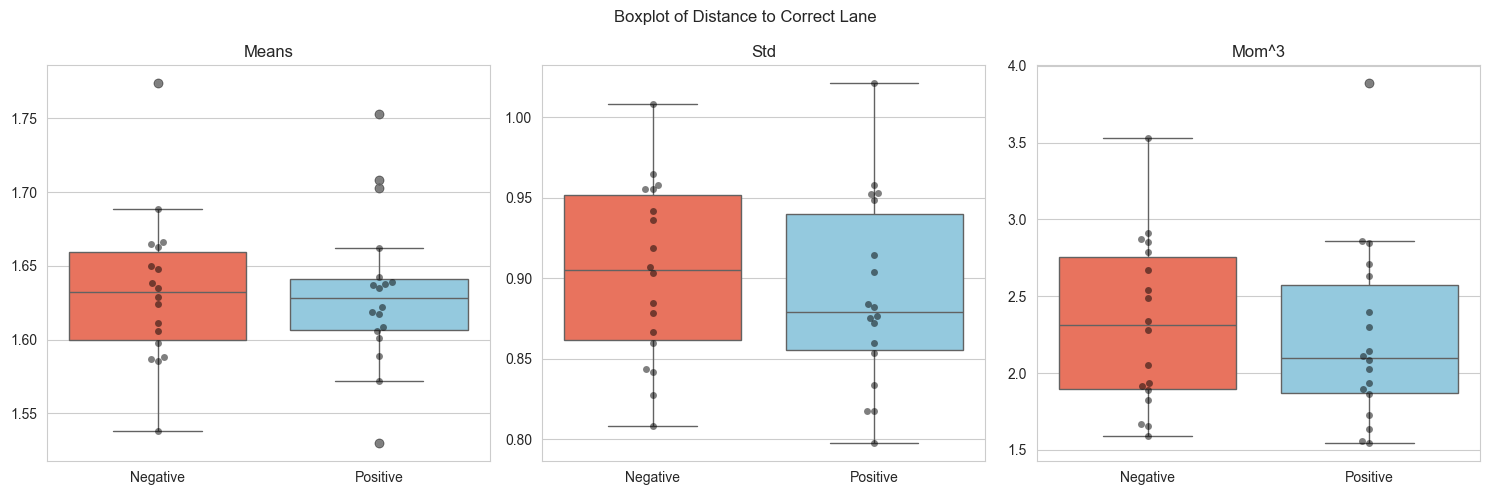

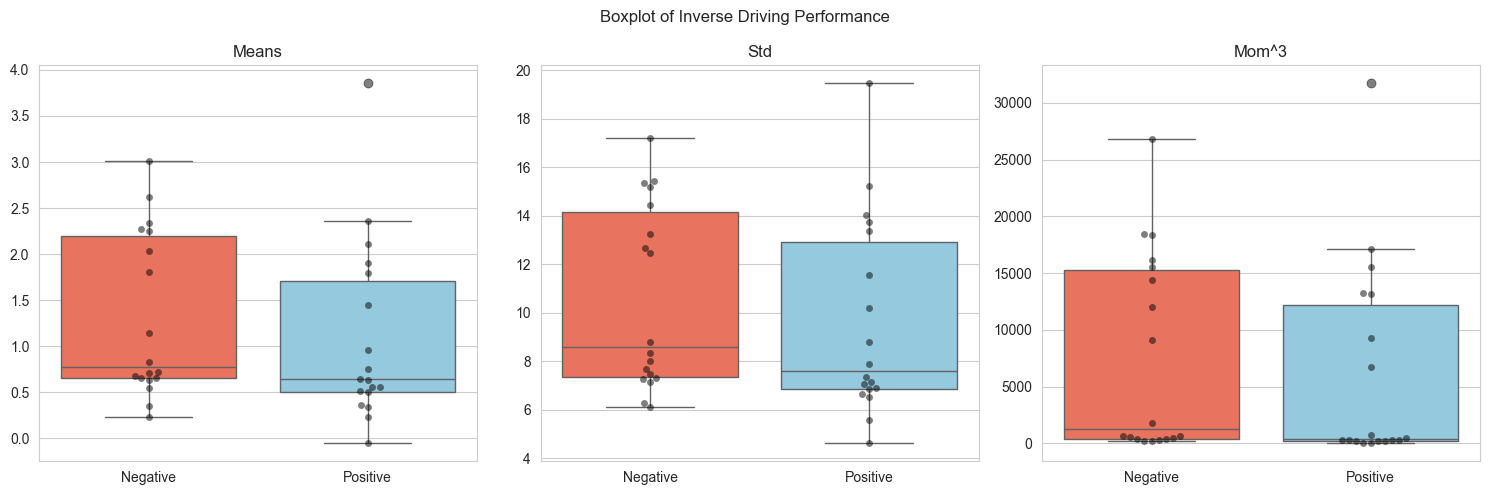

In [ ]:
plot_all_boxplot_perf(datasets=datasets, titles=titles)

In [ ]:
%matplotlib agg

intense_stats_wo, calm_stats_wo = get_all_stats(remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/wo_events/')
dataset_wo = generate_datasets(calm_stats=calm_stats_wo, intense_stats=intense_stats_wo, pairs=pairs)

%matplotlib inline

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
D0P7X9W6 OK
G2Y7J4Q1 OK
G9K4W1Z0 OK
I8L4N6G7 OK
J4X1T0D2 OK
J6W7Q4H5 OK
K4G7Y9O2 OK
L0S1Z2I3 OK
L1N3B5O2 OK
M0R6U5F9 OK
M4H6R2W9 OK
M7D3F5K4 OK
N7P5B8G0 OK
O4A0U8R1 OK
U6O5V2T9 OK
V9L0P2K7 OK
X5Q0G4J2 OK
Z6A2W1E8 OK


In [ ]:
# plot_all_perf_param_kdes(datasets=dataset_wo, titles=titles)

In [ ]:
print(len([x for x,_,_ in dataset_wo[0][1] if x not in [None, np.nan, 'NaN', 'nan']]))
for j, (intense, calm) in enumerate(dataset_wo):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')

NameError: name 'dataset_wo' is not defined

In [ ]:
# plot_all_boxplot_perf(datasets=dataset_wo, titles=titles)

In [ ]:
speed_intense = datasets[1][0]
speed_calm = datasets[1][1]

### Analyze Gender Dependencies

##### Male only

In [ ]:
%matplotlib agg

calm_man, intense_man = get_all_stats(drop_gender='FEMALE', save_folder='perf_plots/men/')
dataset_man = generate_datasets(calm_stats=calm_man, intense_stats=intense_man, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man, titles=titles)

%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.8966255274417589
STDs: 0.6411000442012771
Mom^3s: 0.8041302498488301

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.5237563333502224
STDs: 0.33810260571861295
Mom^3s: 0.33880064390495923

T-test results for Car Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094


##### With outliers removed

In [ ]:
%matplotlib agg
calm_man_outl, intense_man_outl = get_all_stats(drop_gender='FEMALE',remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/men_outl/')
dataset_man_outl = generate_datasets(calm_stats=calm_man_outl, intense_stats=intense_man_outl, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man_outl, titles=titles)
%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.21455779259860913
STDs: 0.9025188083563968
Mom^3s: 0.21621606147147773

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8597781195951577
STDs: 0.8554482696474912
Mom^3s: 0.6685909656924475

T-test results for Car Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094


##### Female only

In [ ]:
%matplotlib agg
calm_man, intense_man = get_all_stats(drop_gender='MALE', save_folder='perf_plots/women/')
dataset_man = generate_datasets(calm_stats=calm_man, intense_stats=intense_man, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man, titles=titles)
%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.21455779259860913
STDs: 0.9025188083563968
Mom^3s: 0.21621606147147773

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8597781195951577
STDs: 0.8554482696474912
Mom^3s: 0.6685909656924475

T-test results for Car Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094


##### With outliers removed

In [ ]:
%matplotlib agg
calm_man_outl, intense_man_outl = get_all_stats(drop_gender='MALE',remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/women_outl/')
dataset_man_outl = generate_datasets(calm_stats=calm_man_outl, intense_stats=intense_man_outl, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man_outl, titles=titles)
%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.257723898374721
STDs: 0.4108794815425716
Mom^3s: 0.5511735750053153

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.4801060800460869
STDs: 0.8806314528291882
Mom^3s: 0.571620772560518

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8640353113177037
STDs: 0.6377910003602814
Mom^3s: 0.3909064506267478

T-test results for Car Speed, intense vs calm:
Means: 0.4801060800460869
STDs: 0.8806314528291882
Mom^3s: 0.571620772560518


### Analyzing ordering effect

#### PN 

In [ ]:
%matplotlib agg

calm_pn, intense_pn = get_all_stats(drop_order='NP', remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/PN/')
dataset_pn = generate_datasets(calm_stats=calm_pn, intense_stats=intense_pn, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_pn, titles=titles)

%matplotlib inline

In [ ]:
from scipy.stats import kruskal
for j, (intense, calm) in enumerate(dataset_pn):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
    print(f'\nKruskal results for {titles[j]}, intense vs calm:')
    print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.15226117407634776
STDs: 0.11007925873311876
Mom^3s: 0.3714016998386561

Kruskal results for Lateral Velocity, intense vs calm:
Means: 0.22647606604348455
STDs: 0.7623688184698474
Mom^3s: 1.0

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.6890271361382726
STDs: 0.5530033330860247
Mom^3s: 0.6122161211799042

Kruskal results for Difference to Correct Speed, intense vs calm:
Means: 0.8205958397554376
STDs: 0.36434612663355204
Mom^3s: 0.8798291600118151

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.046155774177329995
STDs: 0.045667990277228517
Mom^3s: 0.08942129158753905

Kruskal results for Distance to Correct Lane, intense vs calm:
Means: 0.5967012167293555
STDs: 0.5967012167293555
Mom^3s: 0.6501474440948595

T-test results for Car Speed, intense vs calm:
Means: 0.6890271361382726
STDs: 0.5530033330860247
Mom^3s: 0.6122161211799042

Kruskal results for Car Speed, intense v

#### NP

In [ ]:
%matplotlib agg
calm_np, intense_np = get_all_stats(drop_order='PN', remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/NP/')
dataset_np = generate_datasets(calm_stats=calm_np, intense_stats=intense_np, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_np, titles=titles)

%matplotlib inline

In [ ]:
from scipy.stats import kruskal
for j, (intense, calm) in enumerate(dataset_np):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
    print(f'\nKruskal results for {titles[j]}, intense vs calm:')
    print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.3556519914590071
STDs: 0.36067970444815245
Mom^3s: 0.12628805976909227

Kruskal results for Lateral Velocity, intense vs calm:
Means: 0.3538369006847303
STDs: 0.6911022238448452
Mom^3s: 0.5659921481957904

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.644533146825903
STDs: 0.3636708903682214
Mom^3s: 0.8302095343675412

Kruskal results for Difference to Correct Speed, intense vs calm:
Means: 0.9647839776414967
STDs: 0.4015419876158456
Mom^3s: 0.9647839776414967

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.20118904874593646
STDs: 0.20083928279739688
Mom^3s: 0.23715261185316996

Kruskal results for Distance to Correct Lane, intense vs calm:
Means: 0.8946258095467479
STDs: 0.8252828980151854
Mom^3s: 0.8252828980151854

T-test results for Car Speed, intense vs calm:
Means: 0.644533146825903
STDs: 0.3636708903682214
Mom^3s: 0.8302095343675412

Kruskal results for Car Speed, 